In [22]:
import os
import random
import itertools
import cv2 as cv
import numpy as np
import tensorflow as tf
from sklearn import metrics
from tensorflow import keras
from collections import Counter
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten

In [23]:
np.random.seed(7)
female = []
male = []

for i in os.listdir('C:/Users/72684/Desktop/Reinforcement Learning/Female'):
    path = 'C:/Users/72684/Desktop/Reinforcement Learning/Female/{}'.format(i)
    female.append([cv.imread(path, cv.IMREAD_COLOR) / 255, 0])

for i in os.listdir('C:/Users/72684/Desktop/Reinforcement Learning/Male'):
    path = 'C:/Users/72684/Desktop/Reinforcement Learning/Male/{}'.format(i)
    male.append([cv.imread(path, cv.IMREAD_COLOR) / 255, 1])

female = np.array(female)
male = np.array(male)

f_trn, f_tst = train_test_split(female, test_size = 0.2)
m_trn, m_tst = train_test_split(male, test_size = 0.2)

train = []
test = []

for i in range(len(f_trn)):
    train.append(f_trn[i])
    
for i in range(len(m_trn)):
    train.append(m_trn[i])

for i in range(len(f_tst)):
    test.append(f_tst[i])

for i in range(len(m_tst)):
    test.append(m_tst[i])

random.seed(7)
random.shuffle(train)
random.seed(7)
random.shuffle(test)

train = np.array(train)
test = np.array(test)

trn_d = []
tst_d = []

trn_l = np.zeros(len(train))
tst_l = np.zeros(len(test))

for i in range(len(train)):
    trn_l[i] = train[i, 1]
    trn_d.append(train[i, 0])

for i in range(len(test)):
    tst_l[i] = test[i, 1]
    tst_d.append(test[i, 0])

trn_d = np.array(trn_d)
tst_d = np.array(tst_d)

C:\Users\72684\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  del sys.path[0]
C:\Users\72684\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


In [24]:
def build_model(krnl1, krnl2, krnl3, dns_lr, maps):
    tf.random.set_seed(7)
    
    mdl = Sequential()
    
    mdl.add(Conv2D(maps, krnl1, activation = 'relu', input_shape = (48, 48, 3), padding = "same"))
    mdl.add(MaxPooling2D(2, 2))
    
    mdl.add(Conv2D(2 * maps, krnl2, activation = 'relu', padding = "same"))
    mdl.add(MaxPooling2D(2, 2))
    
    mdl.add(Conv2D(4 * maps, krnl3, activation = 'relu', padding = "same"))
    
    mdl.add(Flatten())
    mdl.add(Dense(dns_lr, activation = 'relu'))
    mdl.add(Dense(1, activation = 'sigmoid'))
    
    mdl.compile(loss = 'binary_crossentropy', optimizer = 'adagrad', metrics = ['accuracy'])
    
    return mdl

In [25]:
def initialize_q_table(state_space, action_space, range_=(-1, 1), zeros=False):
    func = np.zeros if zeros else np.random.random
    qtable = (not zeros) * range_[0] + (range_[1] - range_[0]) * func((state_space, action_space))
    return qtable


def epsilon_greedy_policy(qtable, state, epsilon):
    # Randomly generate a number between 0 and 1
    random_num = np.random.random()
    # if random_num > greater than epsilon --> exploitation
    if random_num > epsilon:
        # Take the action with the highest value given a state
        # np.argmax can be useful here
        action = np.argmax(qtable[state])
    # else --> exploration
    else:
        action = np.random.choice(np.arange(len(qtable[0])))  # Take a random action
    return action


def rec_state_path(x, i, depth, path_):
    if i > 1000:
        i = 1000
    if i in path_:
        return
    path_.append(i)
    if depth == 0:
        return x[i]
    return rec_state_path(x, x[i], depth - 1, path_)


def rec_state(x, i, depth):
    if i > 1000:
        i = 1000
    if depth == 0:
        return x[i]
    return rec_state(x, x[i], depth - 1)


def get_best_params(qtable, env, calc_acc=True):
    x = [np.argmax(qtable[i]) for i in range(len(qtable))]
    y = [
        [rec_state(x, i, 2) for i in range(len(qtable))],
        [rec_state(x, i, 3) for i in range(len(qtable))]
    ]

    y1 = np.zeros(len(qtable[0]))
    for i in range(len(qtable[0])):
        path = []
        rec_state_path(x, i, len(qtable[0]), path)
        for p in path:
            y1[p] += 1
    states = [Counter(i).most_common()[0][0] for i in y] + [np.argmax(y1)]
    if calc_acc:
        accs = [env.step(i)[1] for i in states]
        return [[{k: v for k, v in zip(env.params_names, env.comb[state])}, acc] for state, acc in zip(states, accs)]
    else:
        return [{k: v for k, v in zip(env.params_names, env.comb[state])} for state in states]

In [26]:
class ObjModel:
    def __init__(self, base_model, params, data):
        self.data = data
        self.params = params
        self.params_names = self.params.keys()
        self.comb = self.gen_comb()
        self.observation_space_n = len(self.comb)
        self.action_space_n = len(self.comb)
        self.base_model = base_model
        self.model = None
        self.reset()

    def reset(self):
        state = self.goto_state(0)
        return state

    def goto_state(self, state):
        prms = {k: v for k, v in zip(self.params_names, self.comb[state])}
        prms = np.array(list(prms.items()))[:, 1]
        prms = prms.astype(np.int)
        self.model = self.base_model((prms[2], prms[2]), (prms[3], prms[3]), (prms[4], prms[4]), prms[5], prms[6])
        return state

    def train(self, state):
        prms = {k: v for k, v in zip(self.params_names, self.comb[state])}
        prms = np.array(list(prms.items()))[:, 1]
        prms = prms.astype(np.int)
        tf.random.set_seed(7)
        self.model.fit(self.data[0], self.data[1], epochs = prms[0], batch_size = prms[1], validation_data = (tst_d, tst_l), 
            verbose = False)

    def reward(self):
        return self.model.evaluate(self.data[2], self.data[3], verbose = False)[1]

    def gen_comb(self):
        comb = list(itertools.product(*[self.params[i] for i in self.params]))
        return comb

    def step(self, action):
        state = self.goto_state(action)
        self.train(state)
        r = self.reward()
        return state, r


def train(epsilon, decay_rate, env, max_steps, qtable, gamma, learning_rate):
    episode_rewards = [[], []]
    reward_old = 0
    reward_best = 0
    # Reset the environment
    state = env.reset()

    # repeat
    for step in range(max_steps):
        # Choose the action At using epsilon greedy policy
        action = epsilon_greedy_policy(qtable, state, epsilon * np.exp(-decay_rate * step))

        # Take action At and observe Rt+1 and St+1
        # Take the action (a) and observe the outcome state(s') and reward (r)
        new_state, reward_ = env.step(action)
        reward = reward_ if reward_ >= reward_old else (reward_ - reward_old) * 10
        if reward_ > reward_best:
            if step > 0:
                reward *= 2
            reward_best = reward_
        reward_old = reward_

        action_ = epsilon_greedy_policy(qtable, new_state, epsilon)

        # Update Q(s,a)
        qtable[state][action] += learning_rate * (
                reward + gamma * qtable[new_state][action_] - qtable[state][action])

        # Our state is the new state
        state = new_state
        episode_rewards[0].append(reward_)
        episode_rewards[1].append(reward)
    return qtable, episode_rewards

In [27]:
# Environment parameters
params = {
            'epochs': np.arange(5, 36, 10), 
            'batch_size': np.arange(5, 36, 10),
            'kernel_1': [3, 5, 7],
            'kernel_2': [3, 5, 7],
            'kernel_3': [3, 5, 7],
            'dense_layer': np.arange(70, 131, 30),
            'maps': np.arange(8, 25, 8)
        }
data = (trn_d, trn_l, tst_d, tst_l)
env = ObjModel(build_model, params, data)     # environment
# Training parameters
learning_rate = 1          # Learning rate
max_steps = 20            # Max steps per episode
gamma = 0.9                 # Discounting rate

# Exploration parameters
epsilon = 1.0
decay_rate = 0.005            # Exponential decay rate for exploration prob

C:\Users\72684\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [28]:
state_space = env.observation_space_n # TODO
action_space = env.action_space_n # TODO
Qtable_init_s = initialize_q_table(state_space, action_space)

Qtable_s, episod_rewards_s = train(epsilon, decay_rate, env, max_steps, Qtable_init_s, gamma, learning_rate)

params = get_best_params(Qtable_s, env, calc_acc=True)

C:\Users\72684\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\72684\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:27: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release no

C:\Users\72684\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\72684\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:27: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release no

C:\Users\72684\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\72684\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:27: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release no

In [29]:
accs = [i[1] for i in params]
print(accs, 'best acc:', np.max(accs))

[0.7, 0.7, 0.725] best acc: 0.725


In [30]:
print('best params:', params[np.argmax(accs)][0])

best params: {'epochs': 15, 'batch_size': 5, 'kernel_1': 3, 'kernel_2': 5, 'kernel_3': 3, 'dense_layer': 70, 'maps': 16}


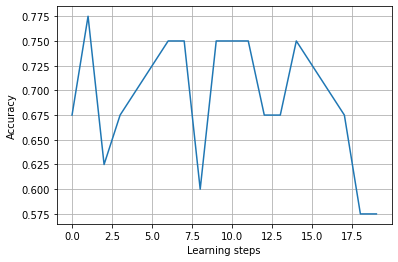

In [31]:
#plt.plot(episod_rewards)
#plt.plot(np.cumsum(episod_rewards_s[1]))
plt.plot(episod_rewards_s[0])
#plt.plot(episod_rewards_s[1])
plt.grid()
plt.xlabel('Learning steps')
plt.ylabel('Accuracy')
plt.show()

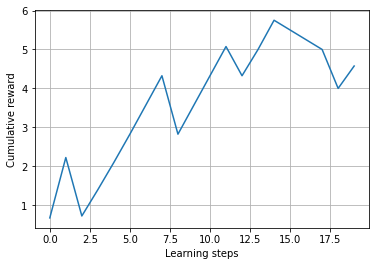

In [32]:
#plt.plot(episod_rewards)
plt.plot(np.cumsum(episod_rewards_s[1]))
#plt.plot(episod_rewards_s[0])
#plt.plot(episod_rewards_s[1])
plt.grid()
plt.xlabel('Learning steps')
plt.ylabel('Cumulative reward')
plt.show()

In [14]:
np.arange(4, 33, 3)

array([ 4,  7, 10, 13, 16, 19, 22, 25, 28, 31])